<a href="https://colab.research.google.com/github/subhabrata-ghosh-1988/Transformers/blob/main/sarcasm-detection-using-bert-base-uncased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Sarcasm Detection 

Sarcasm detection unlike sentiment analysis or simple text classification requires a lot of information about human interaction semantics, the model needs to know about how humans actually interact and it also needs to know the context in which certain words are used while being sarcastic and when not sarcastic.

### In this notebook, we will try using the BERT classifier.

## BERT - Bidirectional Encoder Representations from Transformers

1. BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. 
2. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. 
3. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. 
4. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which was previously impossible.

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install --upgrade pip

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import random
import torch
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
!pip install transformers
import transformers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 3.5 MB 4.6 MB/s 
     |████████████████████████████████| 67 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 6.8 MB 39.1 MB/s 
     |████████████████████████████████| 895 kB 46.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
def set_seed(seed):
        # For reproducibility
        os.environ['PYTHONHASHSEED']=str(seed)
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [5]:
set_seed(42)

## 1. Importing Data

In [7]:
df = pd.read_json("https://raw.githubusercontent.com/subhabrata-ghosh-1988/Transformers/main/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [8]:
df.drop('article_link', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


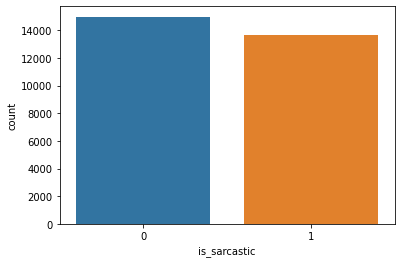

In [10]:
sns.countplot(df['is_sarcastic'])
plt.show()

## 2. Basic Data Cleaning

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

## 3. Creating the vocabulary

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'area': 494,
 'day': 435,
 'donald': 472,
 'like': 428,
 'man': 1351,
 'new': 1637,
 'one': 527,
 'says': 482,
 'trump': 1284,
 'woman': 483}

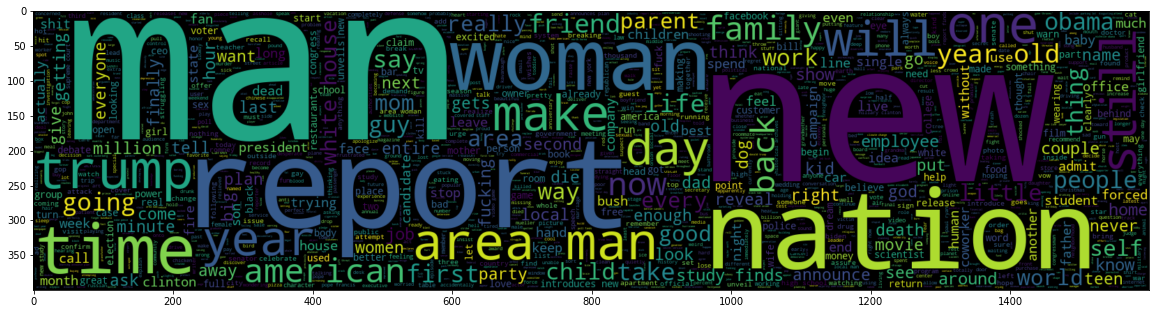

In [13]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 400).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

In [15]:
df['message_len'] = df['headline'].apply(lambda x: len(x.split(' ')))
df.head()

,is_sarcastic,headline,message_len
0,1,thirtysomething scientists unveil doomsday clo...,8
1,0,dem rep. totally nails why congress is falling...,13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting t...,8
4,1,mother comes pretty close to using word 'strea...,9


In [17]:
from plotly import graph_objs as go

In [19]:
# Defining all our palette colours.
primary_blue = "#496595"
primary_red = "#eb345b"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

In [20]:
sarcastic_df = df[df['is_sarcastic'] == 1]['message_len'].value_counts().sort_index()
not_sarcastic_df = df[df['is_sarcastic'] == 0]['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=sarcastic_df.index,
    y=sarcastic_df.values,
    name='Sarcastic',
    fill='tozeroy',
    marker_color=primary_red,
))
fig.add_trace(go.Scatter(
    x=not_sarcastic_df.index,
    y=not_sarcastic_df.values,
    name='Acclaim',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

In [24]:
def word_split(text):
    text = re.split('\W+', text)
    return text

df['tokenized'] = df['headline'].apply(lambda x: word_split(x.lower()))
df.head()

,is_sarcastic,headline,message_len,tokenized
0,1,thirtysomething scientists unveil doomsday clo...,8,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep. totally nails why congress is falling...,13,"[dem, rep, totally, nails, why, congress, is, ..."
2,0,eat your veggies: 9 deliciously different recipes,7,"[eat, your, veggies, 9, deliciously, different..."
3,1,inclement weather prevents liar from getting t...,8,"[inclement, weather, prevents, liar, from, get..."
4,1,mother comes pretty close to using word 'strea...,9,"[mother, comes, pretty, close, to, using, word..."


## 4. Model Building

In [ ]:
X_data = df[['headline']].to_numpy().reshape(-1)
y_data = df[['is_sarcastic']].to_numpy().reshape(-1)

In [ ]:
X = df['headline']
y = df['is_sarcastic']

In [ ]:
##X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce


In [ ]:
!pip install transformers
## If transformers library is not installed

#### BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).

In [ ]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

Before any sentence is passed into the BERT model, it has to go through some tokenization steps. 
1. Firstly, tokenize all words in the sentence corpus
2. Next, all the tokens are embedded using the learned embeddings from a WordPiece Tokenizer. For each word we get 786 dim. vector representation.
3. Segment Embedding - Helps in distinguishing the words belonging to different sentences.
4. Positional Embedding - This is used to provide the positional understanding for each word.

![](https://miro.medium.com/max/875/0*m_kXt3uqZH9e7H4w.png)

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
x_train = fast_encode(X_train, fast_tokenizer, maxlen=40)
x_test = fast_encode(X_test, fast_tokenizer, maxlen=40)

We shall be using the pre-trained BERT model which has been extensively trained on huge text corpuses of Wikipedia.
Now after getting the pre-trained model, we can fine-tune the model for our own specific task.

The key thing to notice is here is that for our final prediction we would only be using the output generated by the first token ([CLS]), after which we use a sigmoid activation for final prediction.

In [ ]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Downloading the pre-trained BERT model.
We can use either the CASED or the UNCASED version for model building.

To explain the BERT training in simple words:
The BERT pre-training consists of two steps which happen parallely, these include:
### 1. Masked Language Model
In this the model is provided with sentences and some of the words are masked with a [MASK] tag (15% of all words), the model is then asked to predict those masked words. The BERT loss function takes into consideration only the prediction of the masked values and ignores the prediction of the non-masked words. As a consequence, the model converges slower than directional models, a characteristic which is offset by its increased context awareness.

### 2. Next Sentence Prediction
In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. This helps the model to understand the relationships between

In [ ]:
bert_model = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = build_model(bert_model, max_len=40)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 40)]             0         
                                                                 
 tf_bert_model_2 (TFBertMode  TFBaseModelOutputWithPoo  109482240
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             40, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

In [ ]:
history = model.fit(x_train,y_train,batch_size = 16 ,validation_data=(x_test,y_test),epochs = 3)

Epoch 1/3
1253/1253 [==============================] - 514s 354ms/step - loss: 0.4500 - accuracy: 0.7858 - val_loss: 0.3596 - val_accuracy: 0.8372
Epoch 2/3
1253/1253 [==============================] - 439s 350ms/step - loss: 0.2548 - accuracy: 0.8978 - val_loss: 0.4234 - val_accuracy: 0.8376
Epoch 3/3
1253/1253 [==============================] - 439s 351ms/step - loss: 0.1100 - accuracy: 0.9590 - val_loss: 0.5449 - val_accuracy: 0.8482


In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

269/269 [==============================] - 48s 180ms/step - loss: 0.5449 - accuracy: 0.8482
Accuracy of the model on Testing Data is -  84.82413291931152 %


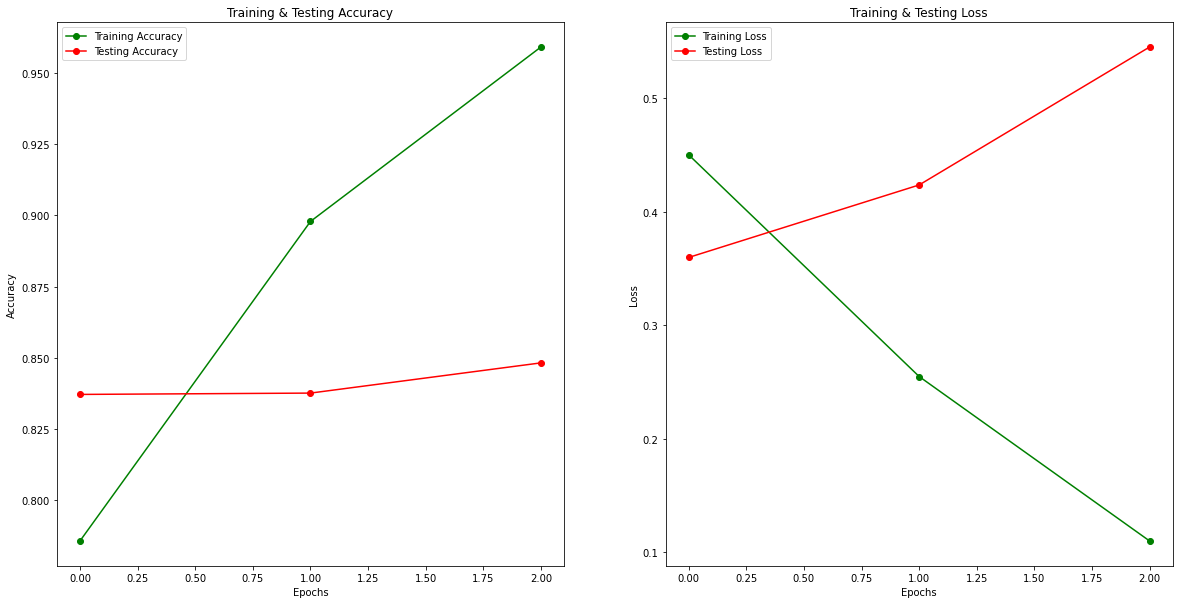

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict(x_test)
pred[:5]

array([[9.9979752e-01],
       [9.9997175e-01],
       [6.4103283e-02],
       [9.9448329e-01],
       [2.3109646e-04]], dtype=float32)

In [ ]:
pred = np.round(pred).astype(int)
pred[:5]

array([[1],
       [1],
       [0],
       [1],
       [0]])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4458
           1       0.84      0.85      0.84      4128

    accuracy                           0.85      8586
   macro avg       0.85      0.85      0.85      8586
weighted avg       0.85      0.85      0.85      8586



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[3777,  681],
       [ 622, 3506]])

Text(69.0, 0.5, 'Actual')

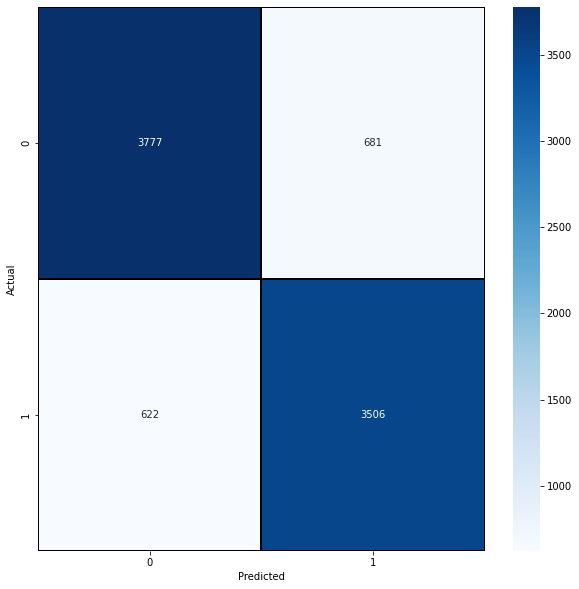

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("bert-model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("bert-model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
from transformers import BertTokenizer, TFBertModel

In [ ]:
# load json and create model
json_file = open('bert-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json,custom_objects={'TFBertModel': TFBertModel})
# load weights into new model
loaded_model.load_weights("bert-model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.compile(Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    

In [ ]:
print("Accuracy of the model on Testing Data is - " , loaded_model.evaluate(x_test,y_test)[1]*100 , "%")

269/269 [==============================] - 55s 179ms/step - loss: 0.5449 - accuracy: 0.8482
Accuracy of the model on Testing Data is -  84.82413291931152 %


In [ ]:
x_train = fast_encode(X_train, fast_tokenizer, maxlen=40)

In [ ]:
input_L = model.layers[0](x_train[:1000])
bert_m = model.layers[1]
outputs = bert_m(input_L)
last_hidden_states = outputs.last_hidden_state
last_hidden_states

<tf.Tensor: shape=(1000, 40, 768), dtype=float32, numpy=
array([[[-1.0345747 ,  0.06177528, -0.34631115, ..., -0.41621795,
          0.9178313 ,  0.600635  ],
        [-0.7079441 ,  0.41612402, -0.20616853, ..., -0.41093704,
          0.92840254,  1.1381966 ],
        [-0.777426  ,  0.14183238,  0.57115984, ..., -0.9360045 ,
          0.06014167,  0.5915246 ],
        ...,
        [-0.4694136 ,  0.2477426 , -0.0575156 , ..., -0.14384149,
          0.56086206, -0.15736991],
        [-0.5145774 ,  0.24585798, -0.03131276, ..., -0.12058242,
          0.55089605, -0.09109575],
        [-0.5737689 ,  0.32929954, -0.00378598, ..., -0.10828002,
          0.5791819 , -0.05040786]],

       [[-0.23959702, -0.09642766,  0.08081056, ..., -0.21989486,
         -0.314659  ,  0.91538227],
        [ 1.0056316 , -0.23303196,  0.21636133, ..., -0.17919213,
         -0.07622781, -0.5317474 ],
        [ 1.0877078 ,  0.07722266, -0.33881894, ...,  0.28124204,
         -0.62748647, -0.35697496],
        ..

In [ ]:
cls_token = last_hidden_states[:, 0, :]

In [ ]:
cls_token.shape

TensorShape([1000, 768])

In [ ]:
from sklearn.manifold import TSNE
dim_reducer = TSNE(n_components=2,random_state=0)
layer_dim_reduced_embeds = dim_reducer.fit_transform(cls_token)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
layer_dim_reduced_embeds

array([[ 15.232818,  26.80942 ],
       [-15.176206,  -6.397918],
       [ 32.90127 ,   8.480393],
       ...,
       [ 13.181394,  15.873233],
       [-26.816088,  -5.165973],
       [-30.75197 ,  -3.484681]], dtype=float32)

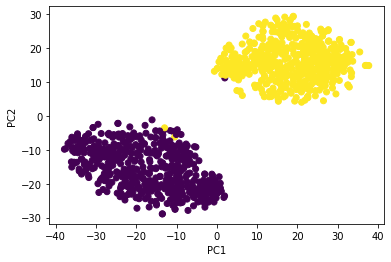

In [ ]:
plt.scatter(layer_dim_reduced_embeds[:,0], layer_dim_reduced_embeds[:,1],c=y_train[0:1000])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()